# Reference
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


# Load the data

In [1]:
import pandas as pd
import os
import hashlib

# langchain documents
from langchain_community.vectorstores import Qdrant
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [2]:
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

In [3]:
def create_document(file_path):
    # Read the content of the file
    content = read_file(file_path)
    
    file_name = os.path.basename(file_path)\
    
    # Strip the .txt suffix and replace underscores with slashes
    source_url = file_name.replace('.txt', '').replace('_', '/')
    metadata = {"source": source_url}
    
    # Create a Document object with content and metadata
    return Document(page_content=content, metadata=metadata)

In [4]:
def find_txt_files(directories):
    txt_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.txt'):
                    txt_files.append(os.path.join(root, file))
    return txt_files

In [5]:
data_directories = [
    '../data/mids_site_content/courses/without_whitespace',
    '../data/mids_site_content/intranet/without_whitespace',
    '../data/mids_site_content/public_pages/without_whitespace'
]

In [6]:
file_paths = find_txt_files(data_directories)
documents = [create_document(file_path) for file_path in file_paths]

In [7]:
d = {"page_content": [doc.page_content for doc in documents], "metadata": [doc.metadata for doc in documents]}
docs_df = pd.DataFrame(d)

In [8]:
docs_df

,page_content,metadata
0,Data Science 210A. Capstone for Early Career D...,{'source': 'www.ischool.berkeley.edu/courses/d...
1,Data Science 261. Machine Learning at Scale | ...,{'source': 'www.ischool.berkeley.edu/courses/d...
2,Data Science 271. Statistical Methods for Disc...,{'source': 'www.ischool.berkeley.edu/courses/d...
3,Data Science 266. Natural Language Processing ...,{'source': 'www.ischool.berkeley.edu/courses/d...
4,Data Science 200. Introduction to Data Science...,{'source': 'www.ischool.berkeley.edu/courses/d...
...,...,...
66,Data Science Curriculum | UC Berkeley Online S...,{'source': 'ischoolonline.berkeley.edu/data-sc...
67,Master's in Data Science Online | UC Berkeley ...,{'source': 'ischoolonline.berkeley.edu/data-sc...
68,What is Data Science? | The Data Science Caree...,{'source': 'ischoolonline.berkeley.edu/data-sc...
69,Study Applied Statistics - I School Online Ski...,{'source': 'ischoolonline.berkeley.edu/data-sc...


In [9]:
TEXT_COLUMN = 'page_content'
text = docs_df[TEXT_COLUMN]

# Text Statistics

### Character Length Histogram

In [10]:
def plot_character_length_histogram(text):
    text.str.len().hist()

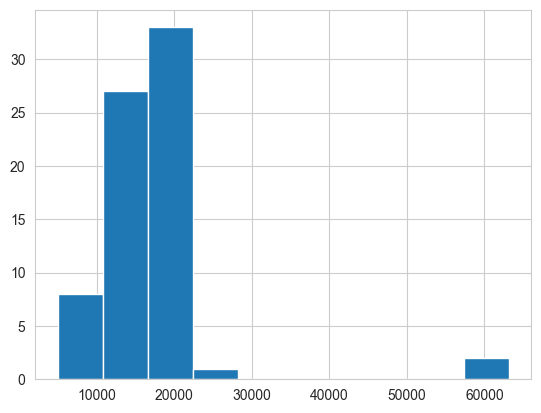

In [11]:
plot_character_length_histogram(text)

### Word Number Histogram

In [12]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

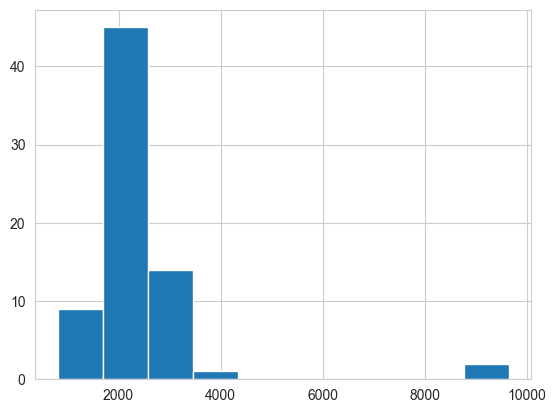

In [13]:
plot_word_number_histogram(text)

### Top Stopwords Barchart

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

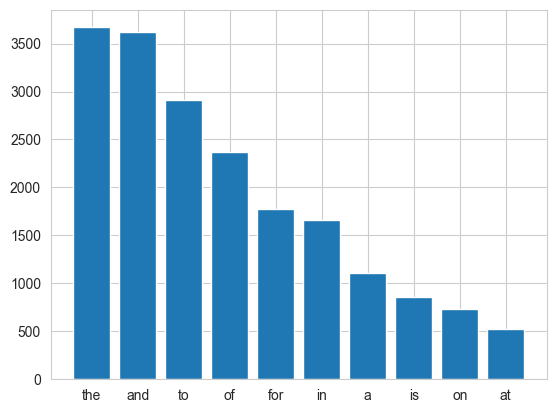

In [15]:
plot_top_stopwords_barchart(text)

### Top Non-Stopwords Barchart

In [16]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
sns.color_palette("viridis", as_cmap=True)

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

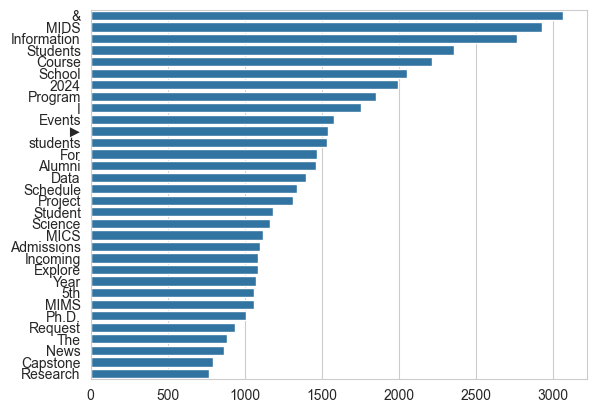

In [17]:
plot_top_non_stopwords_barchart(text)

# Top N-grams Barchart

In [18]:
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

### Bigrams

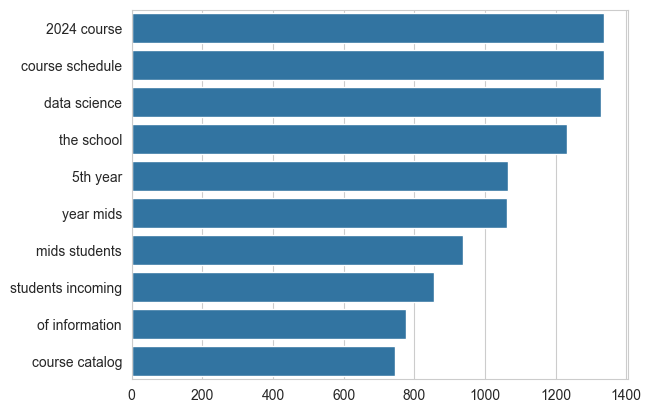

In [19]:
plot_top_ngrams_barchart(text,2)

### Trigrams

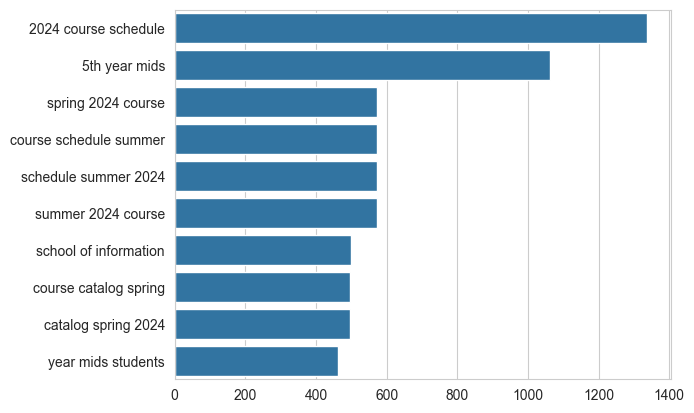

In [20]:
plot_top_ngrams_barchart(text,3)

# Topic Modelling LDA visualization

In [21]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [22]:
lda_model, bow_corpus, dic = get_lda_objects(text)
lda_model.show_topics()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.025*"MIDS" + 0.024*"Information" + 0.020*"2024" + 0.020*"Course" + 0.019*"Students" + 0.019*"School" + 0.016*"Program" + 0.014*"Events" + 0.013*"student" + 0.013*"Alumni"'),
 (1,
  '0.024*"project" + 0.013*"page" + 0.012*"Information" + 0.012*"MIDS" + 0.010*"Students" + 0.009*"School" + 0.009*"gallery" + 0.008*"Project" + 0.008*"Course" + 0.008*"2024"'),
 (2,
  '0.014*"student" + 0.013*"course" + 0.012*"data" + 0.012*"Data" + 0.011*"Students" + 0.011*"MIDS" + 0.008*"Information" + 0.008*"DATASCI" + 0.008*"Science" + 0.007*"program"'),
 (3,
  '0.012*"cooky" + 0.010*"information" + 0.009*"Information" + 0.009*"may" + 0.008*"fee" + 0.008*"label" + 0.008*"Cookies" + 0.007*"Science" + 0.007*"advertising" + 0.007*"Data"')]

In [23]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.199739  0.037133       1        1  79.912134
2     -0.104293  0.070593       2        1  12.674792
3     -0.191194 -0.035756       3        1   5.865872
1      0.095748 -0.071970       4        1   1.547202, topic_info=            Term         Freq        Total Category  logprob  loglift
170  Information  2854.000000  2854.000000  Default  30.0000  30.0000
207         MIDS  2967.000000  2967.000000  Default  29.0000  29.0000
253      Project  1299.000000  1299.000000  Default  28.0000  28.0000
310     Students  2314.000000  2314.000000  Default  27.0000  27.0000
82        Course  2194.000000  2194.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
117      Explore     9.239761  1075.819058   Topic4  -5.4224  -0.5886
90          Data     9.261623  1379.252932   Topic4  -5.4200  -0.8347
27    Admissions     9.087489  1088.736358   Topic4  -5.4390  -0.6172
348         Year     9.075704  1057.703266   Topic4  -5.4403  -0.5895
17           5th     8.876520  1049.877654   Topic4  -5.4625  -0.6043

[337 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2428      3  0.874896   117.50
4044      3  0.809585  117.50¹
4046      3  0.809603    2,712
2429      1  0.099625    2,850
2429      3  0.896629    2,850
...     ...       ...      ...
2154      3  0.546797  website
2154      4  0.040010  website
613       1  0.211486     work
613       2  0.543820     work
613       3  0.231627     work

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

# Wordcloud

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


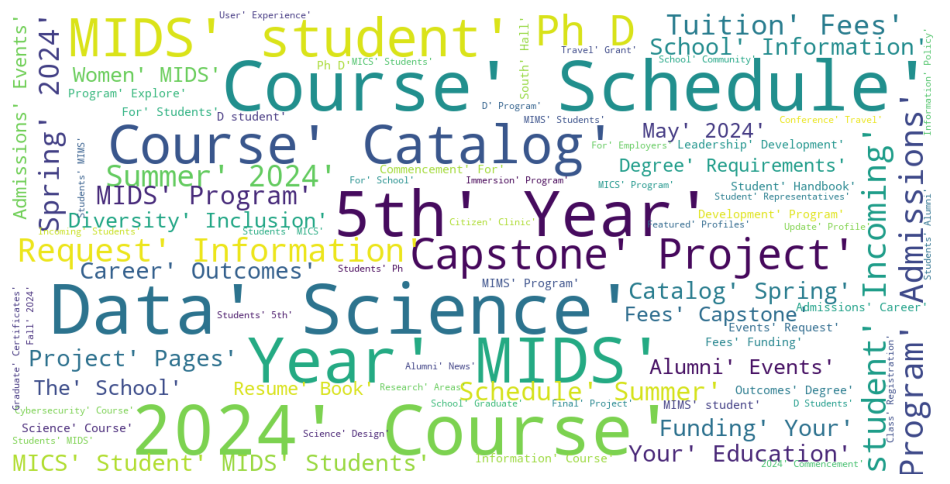

In [25]:
plot_wordcloud(text)

# Text Sentiment

### Polarity Histogram

In [26]:
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

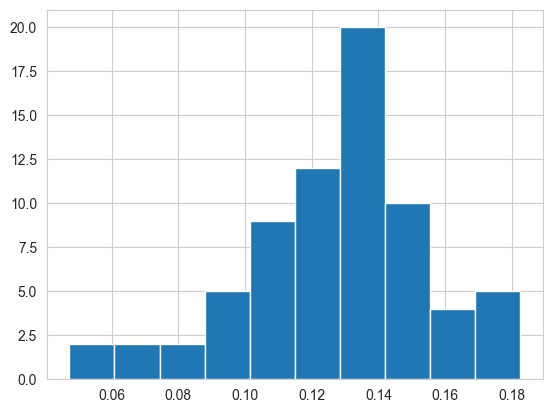

In [27]:
plot_polarity_histogram(text)

### Sentiment Barchart

In [28]:
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

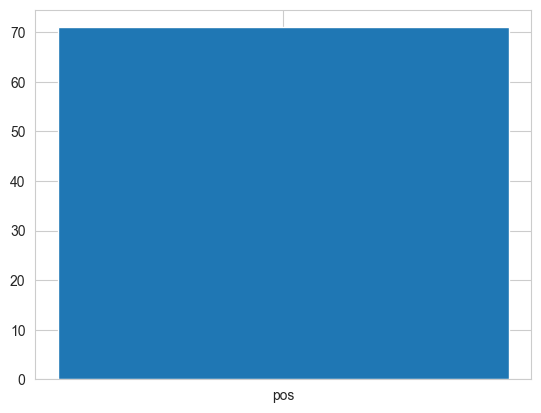

In [29]:
plot_sentiment_barchart(text, method='TextBlob')

# Named Entity Recognition

### Named Entity Barchart

In [30]:
import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

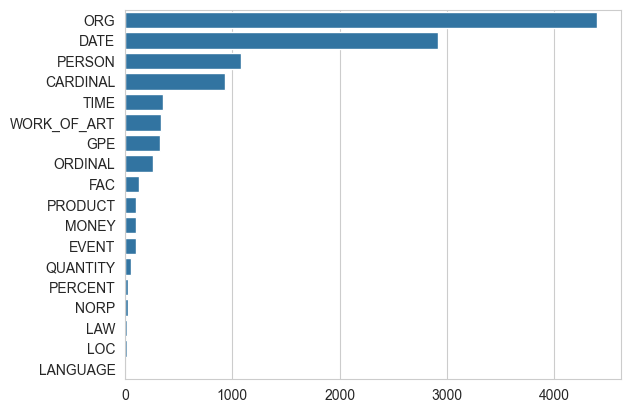

In [31]:
plot_named_entity_barchart(text)

### Most Common Entity Barchart

In [32]:
import spacy
from collections import  Counter
import seaborn as sns
import matplotlib.pyplot as plt

def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y,y=x).set_title(entity)

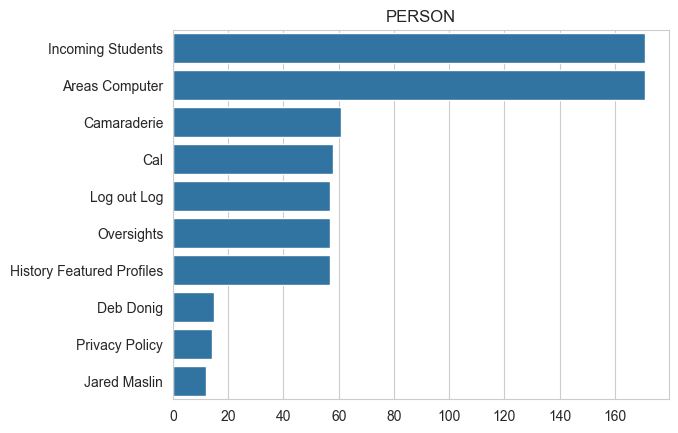

In [33]:
ENTITIES = [
    "PERSON",
    # "NORP",
    # "FAC",
    # "ORG",
    # "GPE",
    # "LOC",
    # "PRODUCT",
    # "EVENT",
    # "WORK_OF_ART",
    # "LAW",
    # "LANGUAGE",
    # "DATE",
    # "TIME",
    # "PERCENT",
    # "MONEY",
    # "QUANTITY",
    # "ORDINAL",
    # "CARDINAL"
]

for entity in ENTITIES:
    try:
        fig = plt.figure()
        plot_most_common_named_entity_barchart(text, entity)
        plt.show()
    except Exception:
        pass

# Parts of Speach Tagging

### Parts of Speach Barchart

In [34]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
from collections import Counter

def plot_parts_of_speach_barchart(text):

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    
    sns.barplot(x=y,y=x)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


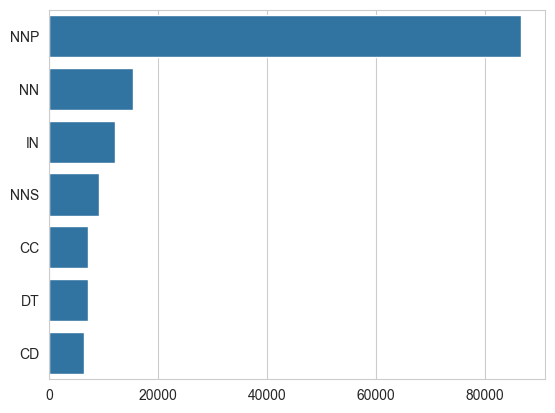

In [35]:
plot_parts_of_speach_barchart(text)

### Most Common Part of Speach Barchart

In [36]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')

import seaborn as sns
from collections import Counter

def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type


    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


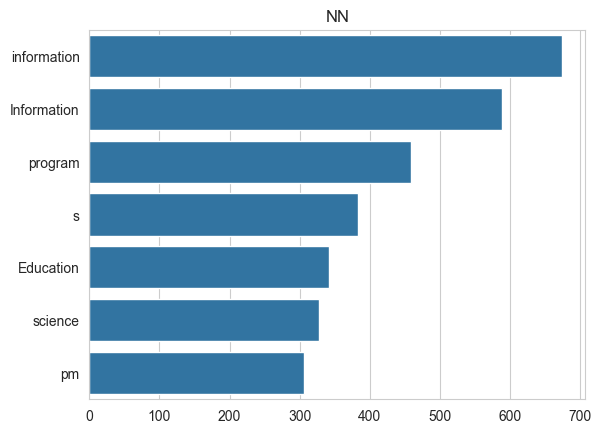

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


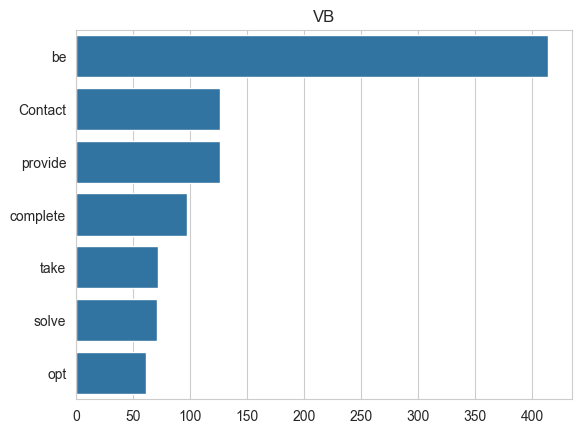

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


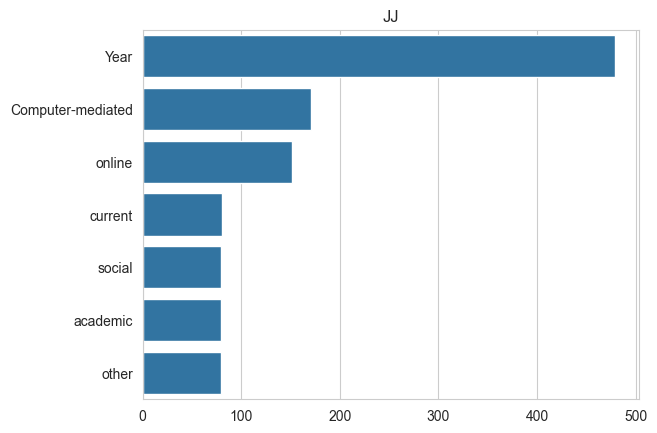

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


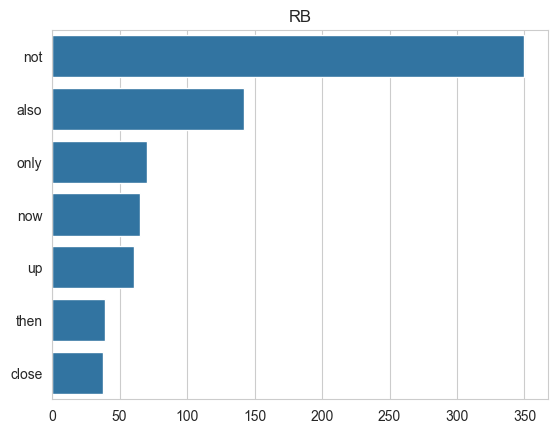

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


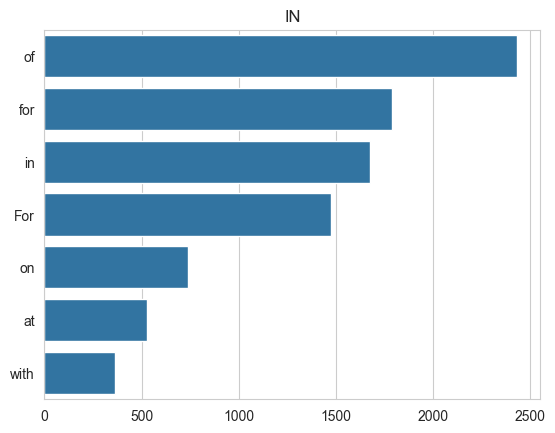

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


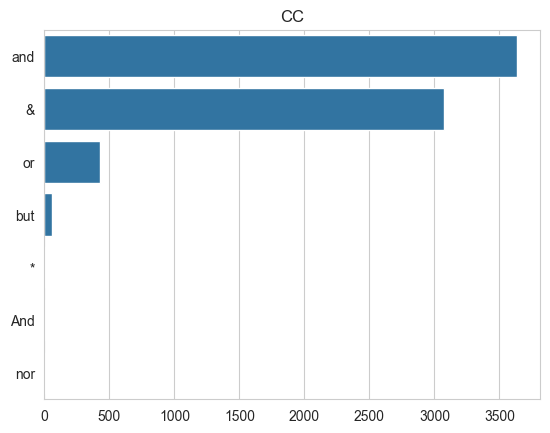

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


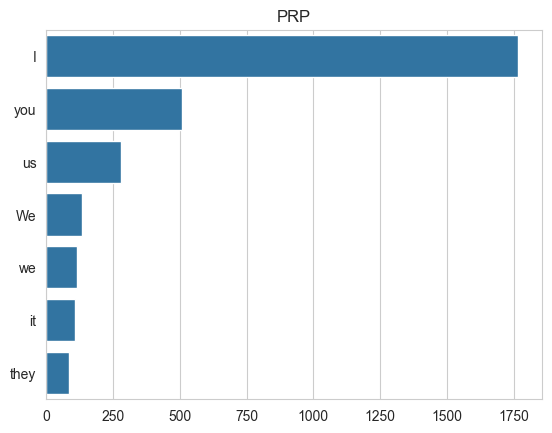

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertgreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<Figure size 640x480 with 0 Axes>

In [37]:
PARTS_OF_SPEACH = [
    "NN",
    "VB",
    "JJ",
    "RB",
    "IN",
    "CC",
    "PRP",
    "INT",
]

for part_of_speach in PARTS_OF_SPEACH:
    try:
        fig = plt.figure()
        plot_most_common_part_of_speach_barchart(text, part_of_speach)
        plt.show()
    except Exception:
        pass

# Text Complexity

### Text Complexity Histogram

In [38]:
from textstat import flesch_reading_ease

def plot_text_complexity_histogram(text):
    text.apply(lambda x : flesch_reading_ease(x)).hist()

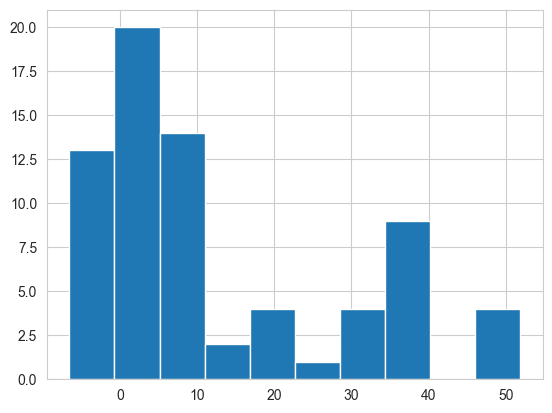

In [39]:
plot_text_complexity_histogram(text)